In [0]:
%pylab inline

import copy
import os
import pickle
import torch
import torchvision

import pandas as pd
from sklearn import metrics
from PIL import Image
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')#, timeout_ms=1000)
path_data = 'small_data/train_sample/'
#path_csv = 'gdrive/My Drive/Colab Notebooks/IDRND_antispoofing_challenge/check_submission_data/'

Mounted at /content/gdrive/


In [0]:
!pwd

/content


In [0]:
# unzip archive of data
!unzip -q /content/gdrive/My\ Drive/IDRND/train_sample_small.zip -d small_data


replace small_data/train_sample/2dmask/2dmask_1/2dmask_1_01.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

------------------------------------------

In [0]:
path_images = []

for label in ['2dmask', 'real', 'printed', 'replay']:
  videos = os.listdir(os.path.join(path_data, label))
  print(videos[0])
  
  for video in videos:
    frames = os.listdir(os.path.join(path_data, label, video))
    print(frames[0])
    
    for frame in frames:
      # create vocabulary of image pathes with labels
      path_images.append({
          'path': os.path.join(path_data, label, video, frame),
          'label': int(label != 'real'),
          'video': video
      })

In [0]:
path_images[0]

{'label': 1,
 'path': 'small_data/train_sample/2dmask/2dmask_84/2dmask_84_04.png',
 'video': '2dmask_84'}

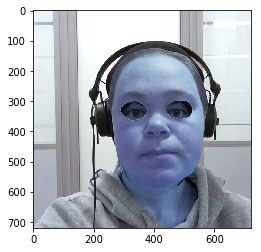

In [0]:
# Visualize image
img = cv2.imread(path_images[0]['path'])
plt.imshow(img)
plt.show()

In [0]:
img.shape

(720, 720, 3)

In [0]:
# Prepare dataset for data
class AntispoofDataset(torch.utils.data.dataset.Dataset):
  def __init__(self, paths, transform=None,
              loader=torchvision.datasets.folder.default_loader):
    self.paths = paths # create paths
    self.transform = transform # create transform list. Check further dataset shape after augmentation
    self.loader = loader
    
  def __getitem__(self, index):
    #print('getitem called')
    image_info = self.paths[index]
    
    img = self.loader(image_info['path']) # get item from path_images dictionary
    if self.transform is not None:
      img = self.transform(img)
      
    return (img, image_info['label']) # check method output
  
  def __len__(self):
    return len(self.paths)

In [0]:
# Split dataset on train and test
test_fraction = 0.1

videos = list(set(x['video'] for x in path_images))
print(len(videos))
print(videos[0])
videos_tr, videos_ts = train_test_split(videos, test_size=0.1, random_state=123)

# split path_images dictionary on train and test
train_path_images = [x for x in path_images if x['video'] in videos_tr]
test_path_images = [x for x in path_images if x['video'] in videos_ts]

print(len(train_path_images))
print(train_path_images[0])

3838
printed_809
17270
{'path': 'small_data/train_sample/2dmask/2dmask_84/2dmask_84_04.png', 'label': 1, 'video': '2dmask_84'}


In [0]:
# Prepare data generators for batch generation + augmentation
data_transforms = {
    'train': torchvision.transforms.Compose([
        torchvision.transforms.Resize(224), # because resnet18 was trained on 224*224 images
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': torchvision.transforms.Compose([
        torchvision.transforms.Resize(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_transforms1 = {
    'train': torchvision.transforms.Compose([
        #torchvision.transforms.Resize(224), # because resnet18 was trained on 224*224 images
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ColorJitter(brightness=0.4,
                                           contrast=0.2,
                                           saturation=0.5),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': torchvision.transforms.Compose([
        #torchvision.transforms.Resize(224),
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_transforms2 = {
    'train': torchvision.transforms.Compose([
        #torchvision.transforms.Resize(224), # because resnet18 was trained on 224*224 images
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomRotation(10),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ColorJitter(brightness=0.6,
                                           contrast=0.4,
                                           saturation=0.7),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
        [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


#image_datasets = {
#    'train': AntispoofDataset(
#                train_path_images, transform=data_transforms['train']
#    ),
#    'val': AntispoofDataset(
#                test_path_images, transform=data_transforms['val']
#    )
#}


Сделаем аугментацию

In [0]:
# Create transform datasets.
# Concat datasets. Check size
tr_dataset1 = AntispoofDataset(train_path_images, transform=data_transforms['train'])
tr_dataset2 = AntispoofDataset(train_path_images, transform=data_transforms1['train'])
tr_dataset3 = AntispoofDataset(train_path_images, transform=data_transforms2['train'])

tr_dataset = torch.utils.data.ConcatDataset([tr_dataset1, tr_dataset2, tr_dataset3])

print(len(tr_dataset1), len(tr_dataset2), len(tr_dataset3), len(tr_dataset))

# Suffle tr_dataset in dataloader
# Add tr_dataset to dictionary with val

image_datasets = {
    'train': tr_dataset,
    'val': AntispoofDataset(
                test_path_images, transform=data_transforms['val']
    )
}


17270 17270 17270 51810


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


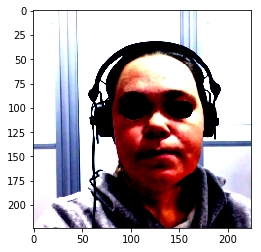

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


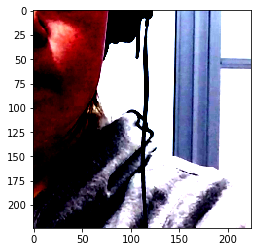

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


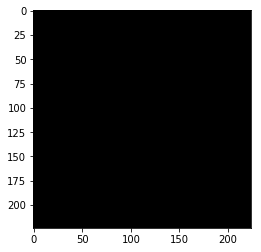

In [0]:
# Check transforms
for data in [tr_dataset1[0], tr_dataset2[0], tr_dataset3[0]]:
  img1 = data[0].numpy()
  img1 = np.transpose(img1, (1,2,0))
  #print(img1[0].shape, img1[0].reshape(224,224,3).numpy().shape)
  print(img1.shape)
  plt.imshow(img1)
  plt.show()

In [0]:

# create dictionary of dataloaders
dataloaders = {
    x: torch.utils.data.DataLoader(
                image_datasets[x], batch_size=64, shuffle=True, num_workers=4 
    ) for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

{'train': 51810, 'val': 1920}


Потсроим базовую модель. Сделаем fine-tuning  Inception v3. Разморозим первые 10 слоев

In [0]:
model = torchvision.models.resnet50(pretrained=True)
model.aux_logits = True # auxilary outputs to avoid gradient atenuation
#model.fc = torch.nn.Linear(model.fc.in_features, 1)
#model = model.to(device)

In [0]:
# check the number of layers
for param in model.parameters():
  param.requires_grad = True

nb_layers = len([param.requires_grad for param in model.parameters()])
nb_layers

161

In [0]:
# freeze last 25 conv layers
layers_to_unfreeze = 70

for i, param in enumerate(model.parameters()):
  if i<= nb_layers - layers_to_unfreeze:
    param.requires_grad = False
  
model.fc = torch.nn.Sequential(
                        #torch.nn.Linear(25088, 4096),#model.classifier.in_features, 4096),
                        torch.nn.Linear(model.fc.in_features, 4096),
                        torch.nn.LeakyReLU(),
                        torch.nn.Dropout(0.2),
                        torch.nn.Linear(4096, 4096),
                        torch.nn.LeakyReLU(),
                        torch.nn.Dropout(0.2),
                        torch.nn.Linear(4096, 1)
)

model = model.to(device)
model

In [0]:
# Check model params
for param in model.parameters():
  print(param.requires_grad)

Обучим сеть. Запомним лучшую точность модели на отложенной выборке

In [0]:
num_epochs = 8

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCEWithLogitsLoss()

since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0

# confusion matrix initialization
confusion_matrix = torch.zeros(2, 2)

for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch, num_epochs - 1))
  print('-' * 10)
  
  for phase in ['train', 'val']:
    if phase == 'train':
      model.train()
    else:
      model.eval()
      
    running_loss = 0
    running_corrects = 0
    running_minC = 0
    
    for inputs, labels in dataloaders[phase]:
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      
      with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs).view(-1)
        
        #print(outputs.shape, labels.shape)

        preds = (outputs>0).long()
        #print(outputs)
        #print(preds)

        loss = criterion(outputs, labels.float())
        
        if phase == 'train':
          loss.backward()
          optimizer.step()
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
      
      #print(preds.shape, labels.shape)
      #print(preds)
      #print(labels)
      
      tn, fp, fn, tp = metrics.confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy()).ravel()
      running_minC += fp / (fp + tn) + 19*fn / (fn + tp)
      print('minC: {:.4f}'.format(fp / (fp + tn) + 19*fn / (fn + tp)))
      #print(tn, fp, fn, tp)
      #print(minC)
      #print(confusion_matrix)
      
    epoch_minC = running_minC / dataset_sizes[phase]
    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]
    
    
    
    print('{}\tLoss: {:.4f}\tAcc: {:.4f}\tminC: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_minC))
    
    if phase == 'val' and epoch_acc > best_acc:
      best_acc = epoch_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      
  print()
  
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

model.load_state_dict(best_model_wts)
  

In [0]:

epoch_minC = running_minC / dataset_sizes[phase]
epoch_loss = running_loss / dataset_sizes[phase]
epoch_acc = running_corrects.double() / dataset_sizes[phase]



print('{}\tLoss: {:.4f}\tAcc: {:.4f}\tminC: {:.4f}'.format(phase, epoch_loss, epoch_acc, epoch_minC))


train	Loss: 0.1515	Acc: 0.9447	minC: 0.0094


In [0]:
preds.cpu().numpy(), labels.cpu().numpy()
confusion_matrix = pd.crosstab(labels.cpu().numpy(), preds.cpu().numpy(), rownames=['Real'], colnames=['Predicted'])

In [0]:
print(confusion_matrix)
print(confusion_matrix.iloc[0,0], confusion_matrix.iloc[0,1], confusion_matrix.iloc[1,0], confusion_matrix.iloc[1,1])
tn, fp, fn, tp = confusion_matrix.iloc[0,0], confusion_matrix.iloc[0,1], confusion_matrix.iloc[1,0], confusion_matrix.iloc[1,1]
minC = fp / (fp + tn) + 19*fn / (fn + tp)
print(minC)


Predicted   0   1
Real             
0           9   5
1          24  26
9 5 24 26
9.477142857142857


In [0]:
#metrics.confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy())
tn, fp, fn, tp = metrics.confusion_matrix(labels.cpu().numpy(), preds.cpu().numpy()).ravel()
print(tn, fp, fn, tp)
minC = fp / (fp + tn) + 19*fn / (fn + tp)
print(minC)

9 5 24 26
9.477142857142857


In [0]:
torch.save(model.state_dict(), 'weights.pt')